In [38]:
%reset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For 3D Plots

#Required by Jupyter for inlining images
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Functions:

In [39]:
def match_datasets(df_1, col_index_1, df_2, col_index_2, lower_epsilon, upper_epsilon):
    #col_indexes are the names of the columns to search (eg. 'Time Stamp')
    #Epsilon is the tolerance in seconds
    
    lenDf = len(df_1.columns) + len(df_2.columns)
    df = pd.DataFrame()#columns=list(range(0,lenDf)))
    
    matched = 0 #Number of elements matched
    dropped_df_1 = 0 #Number of elements dropped from df_1
    dropped_df_2 = 0 #Number of elements dropped from df_2
    
    #Ensure Dataframes are sorted by timestamp
    df_1 = df_1.sort_values(by=[col_index_1]).reset_index()
    df_2 = df_2.sort_values(by=[col_index_2]).reset_index()
    
    i = 0 #keeps track of index of df_1
    j = 0 #keeps track of index of df_2
    while i < len(df_1[col_index_1])-1 and j < len(df_2[col_index_2])-1:
        #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
        if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
            #Case 1:
            #Points matched
            matched = matched + 1
            #Add to new DataFrame:
            row = pd.Series(df_1.iloc[i,:].append(df_2.iloc[j,:])).to_frame().T
            df = df.append(row,ignore_index=True)
            #Increment both i and j
            i = i + 1
            j = j + 1
        #Lookahead on i
        elif df_1[col_index_1][i] < df_2[col_index_2][j]:
            #Case 2:
            i = i + 1
            dropped_df_1 = dropped_df_1 + 1 
            while df_1[col_index_1][i] < df_2[col_index_2][j]:
                #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    i = i + 1
                    dropped_df_1 = dropped_df_1 + 1
        elif df_1[col_index_1][i] > df_2[col_index_2][j]:
            #Case 3:
            j = j + 1
            dropped_df_2 = dropped_df_2 + 1 
            while df_1[col_index_1][i] > df_2[col_index_2][j]:
                #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    j = j + 1
                    dropped_df_2 = dropped_df_2 + 1
                
        
 
    print('Matched: ' + str(matched))
    print('Dropped from 1st df: ' + str(dropped_df_1))
    print('Dropped from 2nd df: ' + str(dropped_df_2))
    #return pd.DataFrame.from_records(rows)
    #print(rows)  
    
    return df

Read the Data:

In [40]:
Data = pd.read_pickle('../Data/dataset.pkl')

In [41]:
Data.head()

,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,1,2,3,4,...,13,14,15,16,17,18,BPM MSE,Time Stamp Bunches,Number of Bunches,Change in Number of Bunches
0,1.534476e+09,1.534476e+09,0.999918,1.534476e+09,0.101479,1.534476e+09,-0.114,-0.035,-1.063,-0.024,...,-1.138,-1.413,0.088,-1.494,-0.411,-0.820,0.000000,1.534476e+09,13.0,13.0
1,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.019902,1.534476e+09,-0.062,-0.134,-0.786,-0.088,...,-1.127,-1.339,0.204,-1.436,-0.358,-0.765,0.013231,1.534476e+09,109.0,96.0
2,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.010375,1.534476e+09,-0.146,0.082,-1.066,0.090,...,-1.098,-1.444,0.073,-1.414,-0.433,-0.730,0.005537,1.534476e+09,121.0,12.0
3,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.008488,1.534476e+09,-0.104,-0.037,-0.872,-0.020,...,-1.143,-1.347,0.132,-1.396,-0.379,-0.668,0.008761,1.534476e+09,265.0,144.0
4,1.534477e+09,1.534477e+09,0.999919,1.534477e+09,0.006452,1.534477e+09,-0.014,-0.008,-0.859,0.053,...,-0.971,-1.447,0.268,-1.489,-0.406,-0.696,0.011608,1.534477e+09,277.0,12.0


Remove Number of Bunches as its not needed now

In [42]:
Data = Data.drop(['Number of Bunches'],axis=1)

Read abort Gap Data

In [43]:
Abort_Gap = pd.read_pickle('../Data/Beam1_AbortGap.pkl')
Abort_Gap.head()

,Time Stamp,Reading,Change in Population
0,1.534476e+09,8.948583e+08,0.000000e+00
1,1.534476e+09,8.604191e+08,-3.443921e+07
2,1.534476e+09,1.557518e+09,6.970988e+08
3,1.534476e+09,2.002396e+09,4.448780e+08
4,1.534477e+09,4.290145e+09,2.287749e+09


In [44]:
Abort_Gap = Abort_Gap.rename(columns={'Time Stamp': 'Time Stamp Abort Gap', 'Reading':'Abort Gap Reading', 
                                      'Change in Population':'Abort Gap Change in Population'})

Matched: 766
Dropped from 1st df: 429
Dropped from 2nd df: 115


Text(0,0.5,'Time Stamp Diff')

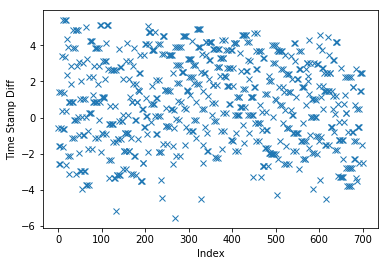

In [45]:
Temp = Data
T_AG = Abort_Gap
Temp = match_datasets(T_AG,'Time Stamp Abort Gap',Temp,'Time Stamp LHC', -6 ,6)

plt.figure()
plt.plot(Temp.index.values,Temp['Time Stamp LHC']-Temp['Time Stamp Abort Gap'],'x')
plt.xlabel('Index')
plt.ylabel('Time Stamp Diff')

In [46]:
Data = match_datasets(Abort_Gap,'Time Stamp Abort Gap',Data,'Time Stamp LHC', -6 ,6)
Data = Data.drop(['index'],axis=1)

Matched: 766
Dropped from 1st df: 429
Dropped from 2nd df: 115


In [47]:
Data['Abort Gap Change in Population'] = (Data['Abort Gap Change in Population']-min(Data['Abort Gap Change in Population']))/(max(Data['Abort Gap Change in Population'])-min(Data['Abort Gap Change in Population']))

## Another 3D LoF

This time with LHC-SPS, Change in Abort Gap Population and TDI BLM

In [48]:
from sklearn.neighbors import LocalOutlierFactor

In [49]:
X = pd.DataFrame(data={'LHC-SPS':Data['LHC-SPS'],'BLM':Data['BLM'],'Abort Gap Change in Population':Data['Abort Gap Change in Population']})
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01, n_jobs=-1).fit_predict(X)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [50]:
X['Predicted Value'] = lof
is_anomaly = X['Predicted Value']==-1
Anomalies = X[is_anomaly]

not_anomaly = X['Predicted Value']!=-1
Inliers = X[not_anomaly]

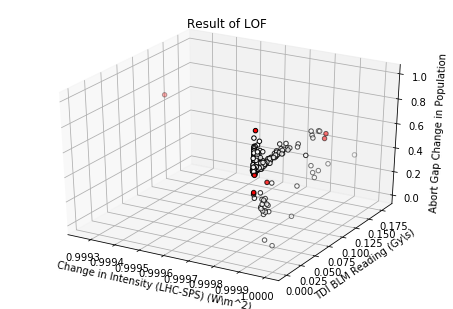

In [51]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['LHC-SPS'],Anomalies['BLM'],Anomalies['Abort Gap Change in Population'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['LHC-SPS'],Inliers['BLM'],Inliers['Abort Gap Change in Population'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('Abort Gap Change in Population')
ax.set_title('Result of LOF')
plt.show()

## Time to add all the BPM Points

In [59]:
Data.head()

,Time Stamp Abort Gap,Abort Gap Reading,Abort Gap Change in Population,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,1,...,12,13,14,15,16,17,18,BPM MSE,Time Stamp Bunches,Change in Number of Bunches
0,1.534476e+09,8.948583e+08,0.705194,1.534476e+09,1.534476e+09,0.999918,1.534476e+09,0.101479,1.534476e+09,-0.114,...,0.049,-1.138,-1.413,0.088,-1.494,-0.411,-0.820,0.000000,1.534476e+09,13.0
1,1.534476e+09,8.604191e+08,0.704211,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.019902,1.534476e+09,-0.062,...,0.101,-1.127,-1.339,0.204,-1.436,-0.358,-0.765,0.013231,1.534476e+09,96.0
2,1.534476e+09,1.557518e+09,0.725074,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.010375,1.534476e+09,-0.146,...,-0.035,-1.098,-1.444,0.073,-1.414,-0.433,-0.730,0.005537,1.534476e+09,12.0
3,1.534476e+09,2.002396e+09,0.717881,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.008488,1.534476e+09,-0.104,...,0.023,-1.143,-1.347,0.132,-1.396,-0.379,-0.668,0.008761,1.534476e+09,144.0
4,1.534477e+09,4.290145e+09,0.770438,1.534477e+09,1.534477e+09,0.999919,1.534477e+09,0.006452,1.534477e+09,-0.014,...,0.025,-0.971,-1.447,0.268,-1.489,-0.406,-0.696,0.011608,1.534477e+09,12.0


In [61]:
## Colmns 9 - 26 need to be normalised
j = 1
for i in range(9,27):
    column = Data.iloc[:,i]
    column = (column-min(column))/(max(column)-min(column))
    Data['BPM Reading '+str(j)] = column
    j = j+1
Data.head()

,Time Stamp Abort Gap,Abort Gap Reading,Abort Gap Change in Population,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,1,...,BPM Reading 9,BPM Reading 10,BPM Reading 11,BPM Reading 12,BPM Reading 13,BPM Reading 14,BPM Reading 15,BPM Reading 16,BPM Reading 17,BPM Reading 18
0,1.534476e+09,8.948583e+08,0.705194,1.534476e+09,1.534476e+09,0.999918,1.534476e+09,0.101479,1.534476e+09,-0.114,...,0.587963,0.459459,0.573082,0.822630,0.156921,0.670673,0.466327,0.277955,0.582043,0.116651
1,1.534476e+09,8.604191e+08,0.704211,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.019902,1.534476e+09,-0.062,...,0.625000,0.506757,0.515195,0.862385,0.165063,0.759615,0.584694,0.370607,0.664087,0.168391
2,1.534476e+09,1.557518e+09,0.725074,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.010375,1.534476e+09,-0.146,...,0.617593,0.577703,0.580318,0.758410,0.186528,0.633413,0.451020,0.405751,0.547988,0.201317
3,1.534476e+09,2.002396e+09,0.717881,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.008488,1.534476e+09,-0.104,...,0.601852,0.591216,0.529667,0.802752,0.153220,0.750000,0.511224,0.434505,0.631579,0.259643
4,1.534477e+09,4.290145e+09,0.770438,1.534477e+09,1.534477e+09,0.999919,1.534477e+09,0.006452,1.534477e+09,-0.014,...,0.560185,0.615991,0.441389,0.804281,0.280533,0.629808,0.650000,0.285942,0.589783,0.233302


Remove old columns

In [63]:
for i in range(1,19):
    Data = Data.drop([i],axis=1)

In [64]:
Data.head()

,Time Stamp Abort Gap,Abort Gap Reading,Abort Gap Change in Population,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,BPM MSE,...,BPM Reading 9,BPM Reading 10,BPM Reading 11,BPM Reading 12,BPM Reading 13,BPM Reading 14,BPM Reading 15,BPM Reading 16,BPM Reading 17,BPM Reading 18
0,1.534476e+09,8.948583e+08,0.705194,1.534476e+09,1.534476e+09,0.999918,1.534476e+09,0.101479,1.534476e+09,0.000000,...,0.587963,0.459459,0.573082,0.822630,0.156921,0.670673,0.466327,0.277955,0.582043,0.116651
1,1.534476e+09,8.604191e+08,0.704211,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.019902,1.534476e+09,0.013231,...,0.625000,0.506757,0.515195,0.862385,0.165063,0.759615,0.584694,0.370607,0.664087,0.168391
2,1.534476e+09,1.557518e+09,0.725074,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.010375,1.534476e+09,0.005537,...,0.617593,0.577703,0.580318,0.758410,0.186528,0.633413,0.451020,0.405751,0.547988,0.201317
3,1.534476e+09,2.002396e+09,0.717881,1.534476e+09,1.534476e+09,0.999919,1.534476e+09,0.008488,1.534476e+09,0.008761,...,0.601852,0.591216,0.529667,0.802752,0.153220,0.750000,0.511224,0.434505,0.631579,0.259643
4,1.534477e+09,4.290145e+09,0.770438,1.534477e+09,1.534477e+09,0.999919,1.534477e+09,0.006452,1.534477e+09,0.011608,...,0.560185,0.615991,0.441389,0.804281,0.280533,0.629808,0.650000,0.285942,0.589783,0.233302
